In [1]:
import torch
import numpy as np
import seaborn as sns
import time as t
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
print('drive mounted')

Mounted at /content/drive
drive mounted


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
## help functions
im_reshape = lambda y: torch.hstack([y[0].reshape((-1,1)),y[1].reshape((-1,1)),y[2].reshape((-1,1))]).reshape(32,32,3).numpy()
de_scale = lambda y: (y+1)/2
def w_loss_dis(fake,real):
    return torch.mean(fake), torch.mean(real)
def w_loss_gen(data):
    return torch.mean(data)
def get_grad_norm(output,data,epsilon):
    gradients = torch.autograd.grad(outputs=output, inputs=data, grad_outputs=torch.ones(output.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
    return ((gradients.view(gradients.size()[0], -1).norm(2, 1) - epsilon) ** 2/epsilon**2).mean()
def save_model():
    torch.save({
            'epochs':epochs,    
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': gen_optimizer.state_dict(),
            'loss': generator_history,
            }, '/content/drive/MyDrive/Colab Notebooks/GAN /Wgan_GP_gen.pth')
    torch.save({
            'epochs':epochs,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': dis_optimizer.state_dict(),
            'loss': discriminator_history,
            },  '/content/drive/MyDrive/Colab Notebooks/GAN /Wgan_GP_dis.pth')
def load_model(generator,discriminator,gen_optimizer,dis_optimizer):
    gen_checkpoint=torch.load('/content/drive/MyDrive/Colab Notebooks/GAN /Wgan_GP_gen.pth')
    generator.load_state_dict(gen_checkpoint['model_state_dict'])
    gen_optimizer.load_state_dict(gen_checkpoint['optimizer_state_dict'])
    dis_checkpoint=torch.load('/content/drive/MyDrive/Colab Notebooks/GAN /Wgan_GP_dis.pth')
    discriminator.load_state_dict(dis_checkpoint['model_state_dict'])
    dis_optimizer.load_state_dict(dis_checkpoint['optimizer_state_dict'])
    return gen_checkpoint,dis_checkpoint
def init_state():
    generator_history = {}
    generator_history['generator_loss'] = []
    generator_history['discriminator_mean_score_on_fake']=[]

    discriminator_history = {}
    discriminator_history['discriminator_loss']=[]
    discriminator_history['gradient norm']=[]
    discriminator_history['sum_discriminator_loss']=[]
    discriminator_history['discriminator_mean_score_on_both']=[]
    return generator_history,discriminator_history

mean = 0.4734
std = 0.2516
images are scaled to interval [-1 , 1 ]

In [4]:
transform = Compose(
    [ToTensor(),
    Normalize((0.5,), (0.5,))])
training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


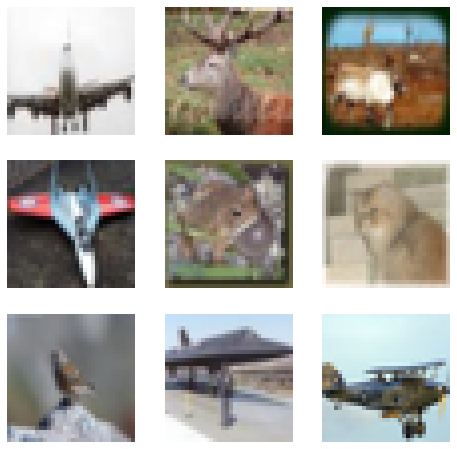

torch.Size([3, 32, 32])


In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3 , 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(img)).squeeze(), cmap="gray")
plt.show()
print(img.squeeze().shape)

In [6]:
## number of output chanels must divisible by number of input channels 
class ResBlock_D(nn.Module):
    def __init__(self,inp,outp,resample='down',padding = 'same'):
        super(ResBlock_D,self).__init__()
        self.inp = inp
        self.outp = outp
        self.resample = resample
        self.conv1 = nn.Conv2d(inp,outp,3,bias = False,padding = padding)
        self.batch1 = nn.BatchNorm2d(outp,momentum = None)
        self.conv2 = nn.Conv2d(outp,outp,3,bias = False,padding = padding)
        self.batch2 = nn.BatchNorm2d(outp,momentum = None)
        self.conv3 = nn.Conv2d(outp,outp,3,bias = False,padding = padding)
        self.batch3 = nn.BatchNorm2d(outp,momentum = None)
        self.highway = nn.Sequential(
            self.conv3,
            self.batch3
        )
    def forward(self,input): # input la (N,C_inp,W,H)
        if self.resample == 'down':
            input = nn.AvgPool2d(4, stride=2, padding=1)(input)
            #input = nn.functional.interpolate(input,scale_factor=0.5)
        res = torch.cat([input for i in range(int(self.outp/self.inp))],dim = 1)
        res = self.highway(res)
        x = self.conv1(input)
        x = self.batch1(x)
        x = nn.LeakyReLU(0.2)(x) # output la (N,C_out,W,H) hoac (N,C_out,W/2,H/2) 
        x = self.conv2(x)
        x = self.batch2(x) # output la (N,C_out,W,H) hoac (N,C_out,W/2,H/2)
        x += res
        x = nn.LeakyReLU(0.2)(x)
        output = nn.Dropout2d(0.25)(x)
        return output # output la (N,C_out,W,H) hoac (N,C_out,W/2,H/2)
rel = ResBlock_D(2,4,resample = 'down')
res = ResBlock_D(2,4,resample = None)
ex = torch.empty((2,2,32,32),requires_grad = False).normal_()
print(f'output shape of this block when resample = down : {rel(ex).shape}')
print(f'output shape of this block when resample = None : {res(ex).shape}')

output shape of this block when resample = down : torch.Size([2, 4, 16, 16])
output shape of this block when resample = None : torch.Size([2, 4, 32, 32])


In [7]:
## number of output chanels must divisible by number of input channels 
class ResBlock_G(nn.Module):
    def __init__(self,inp,outp,resample = 'up',padding = 1):
        super(ResBlock_G,self).__init__()
        self.inp = inp
        self.outp = outp
        self.resample = resample
        self.conv1 = nn.ConvTranspose2d(inp,outp,3,bias = False,padding = padding)
        self.batch1 = nn.BatchNorm2d(outp,momentum = None)
        self.conv2 = nn.ConvTranspose2d(outp,outp,3,bias = False,padding = padding)
        self.batch2 = nn.BatchNorm2d(outp,momentum = None)
        self.conv3 = nn.ConvTranspose2d(outp,outp,3,bias = False,padding = padding)
        self.batch3 = nn.BatchNorm2d(outp,momentum = None)
        self.highway = nn.Sequential(
            self.conv3,
            self.batch3
        )
    def forward(self,input): # input la (N,C_inp,W,H)
        if self.resample == 'up':
            input = nn.functional.interpolate(input,scale_factor=2)
        res = torch.cat([input for i in range(int(self.outp/self.inp))],dim = 1)
        res = self.highway(res)
        x = self.conv1(input)
        x = self.batch1(x)
        x = nn.LeakyReLU(0.2)(x) # output la (N,C_outp,W*2,H*2) hoac (N,C_out,W,H)
        x = self.conv2(x)
        x = self.batch2(x) # output la (N,C_outp,W*2,H*2) hoac (N,C_out,W,H)
        x += res
        output = nn.LeakyReLU(0.2)(x)
        return output # output la (N,C_outp,W*2,H*2) hoac (N,C_out,W,H)
res = ResBlock_G(2,4,resample = 'up')
rel = ResBlock_G(2,4,resample = None)
ex = torch.empty((2,2,32,32),requires_grad = False).normal_()
print(f'output shape of this block when padding = 0 : {res(ex).shape}')
print(f'output shape of this block when padding = 1 : {rel(ex).shape}')

output shape of this block when padding = 0 : torch.Size([2, 4, 64, 64])
output shape of this block when padding = 1 : torch.Size([2, 4, 32, 32])


In [8]:
class Generator(nn.Module):
    def __init__(self,latent):
        super(Generator,self).__init__()     
        self.latent = latent
        self.model = nn.Sequential(
            nn.Linear(self.latent,self.latent*4*4),
            nn.BatchNorm1d(self.latent*4*4,momentum = None),
            nn.Unflatten(1,(self.latent,4,4)),
            nn.LeakyReLU(0.2),
            ResBlock_G(self.latent,self.latent),
            ResBlock_G(self.latent,self.latent),
            ResBlock_G(self.latent,self.latent),
            nn.ConvTranspose2d(self.latent,3,3,padding = 1),
            nn.Tanh()
        )
    def forward(self,norm):
        outp = self.model(norm)
        return outp     
generator = Generator(latent = 99)
print(generator)
rand=torch.empty((2,99)).normal_()
print('size of output is: ',generator(rand).shape)
pytorch_total_params = sum(p.numel() for p in generator.parameters()) 
print('total generator params: ',pytorch_total_params)

Generator(
  (model): Sequential(
    (0): Linear(in_features=99, out_features=1584, bias=True)
    (1): BatchNorm1d(1584, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (2): Unflatten(dim=1, unflattened_size=(99, 4, 4))
    (3): LeakyReLU(negative_slope=0.2)
    (4): ResBlock_G(
      (conv1): ConvTranspose2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch1): BatchNorm2d(99, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
      (conv2): ConvTranspose2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch2): BatchNorm2d(99, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
      (conv3): ConvTranspose2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch3): BatchNorm2d(99, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
      (highway): Sequential(
        (0): ConvTranspose2d(99, 99, kernel_size=(3, 3), stride=(1, 1),

In [9]:
class Discriminator(nn.Module):
    def __init__(self,latent,optim=None):
        super(Discriminator,self).__init__()
        self.optim=optim
        self.decoder=nn.Sequential(
            ResBlock_D(3,latent,resample=None),
            ResBlock_D(latent,latent,resample=None),
            ResBlock_D(latent,latent,resample='down'),
            ResBlock_D(latent,latent,resample='down'),
            nn.Flatten(),
            nn.Linear(6336,1)
        )
    def forward(self,input):
        discri=self.decoder(input)
        return discri
discriminator=Discriminator(99)
rand=torch.empty((2,3,32,32)).normal_()
print(discriminator)
u=discriminator(rand)
print('discri: ',u.shape)
pytorch_total_params = sum(p.numel() for p in discriminator.parameters()) 
print('total discriminator params: ',pytorch_total_params)

Discriminator(
  (decoder): Sequential(
    (0): ResBlock_D(
      (conv1): Conv2d(3, 99, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (batch1): BatchNorm2d(99, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
      (conv2): Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (batch2): BatchNorm2d(99, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
      (conv3): Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (batch3): BatchNorm2d(99, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
      (highway): Sequential(
        (0): Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(99, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
      )
    )
    (1): ResBlock_D(
      (conv1): Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (batch1): BatchNorm2d(99, eps=1e

In [11]:
batch_size=256
learning_rate=0.0002    
n_critics=1
n_student=2
epochs=5
tau=10
epsilon=1
latent=99
generator=Generator(latent).to(device)
discriminator=Discriminator(latent).to(device)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.5,0.9))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.5,0.9))
gen_checkpoint,dis_checkpoint=load_model(generator,discriminator,gen_optimizer,dis_optimizer)

In [ ]:
data=DataLoader(training_data,batch_size=batch_size,shuffle=True)

In [13]:
generator_history = gen_checkpoint['loss']
discriminator_history = dis_checkpoint['loss']

In [ ]:
#generator_history,discriminator_history = init_state()

In [ ]:
for epoch in range(epochs):
    tim = t.time()

    for itter ,(X,Y) in enumerate(data):
        
        X = X.to(device) 
        batch_size=len(X)
        
        #HUAN LUYEN DISCRIMINATOR
        dis_optimizer.zero_grad()
        
        #get a batch of random tensor and fake data
        random_vector = torch.empty((batch_size,latent)).normal_().to(device)
        lambda_v = torch.rand((batch_size, 1, 1, 1)).to(device)
        fake_data = generator(random_vector)
        X.requires_grad = True
        meta = lambda_v*X + (1-lambda_v)*fake_data
        output = discriminator(meta)

        #gradient penalty
        norm=get_grad_norm(output,meta,epsilon)

        #train on REAL data
        real_discriminator_score = discriminator(X)
        
        #train on FAKE data
        fake_discriminator_score = discriminator(fake_data)
        
        #calculate loss
        
        fake_dis_loss , real_dis_loss = w_loss_dis(fake_discriminator_score,real_discriminator_score)
        sum_dis_loss = (fake_dis_loss - real_dis_loss
                        + tau*norm )/(float(n_critics))

        #back-propagation
        sum_dis_loss.backward()
        dis_optimizer.step()
        
        #HUAN LUYEN GENERATOR
        if itter % n_critics == 0:
            for n in range(n_student):
                gen_optimizer.zero_grad()
                
                #get a batch of random tensor and fake data
                random_vector = torch.empty((batch_size,latent)).normal_().to(device)
            
                #get discriminator output
                discriminator_score_gen = discriminator(generator(random_vector))
                
                #calculate loss
                gen_loss = - w_loss_gen(discriminator_score_gen)/float(n_student)
                
                #back propagation
                gen_loss.backward()
                gen_optimizer.step()
        
        #LUU CAC THONG SO NOI
        generator_history['generator_loss'].append(gen_loss.item())
        discriminator_history['sum_discriminator_loss'].append(sum_dis_loss.item())
        discriminator_history['discriminator_loss'].append((real_dis_loss-fake_dis_loss).item())
        discriminator_history['discriminator_mean_score_on_both'].append((real_discriminator_score.mean().item()+fake_discriminator_score.mean().item())/2)
        discriminator_history['gradient norm'].append(norm.item())
        # HIEN THI THONG SO
        if (itter+1) % (len(data)//10) == 0:
            tim = t.time() - tim
            remain = ((epochs - epoch ) * 10 - ((itter+1) // (len(data)//10)) ) * tim
            print(f'[{epoch}/{epochs}][{itter}/{len(data)}]: {round(tim,2)}s  remain: {t.strftime("%H:%M:%S", t.gmtime(remain))}  Loss_D: {(real_dis_loss - fake_dis_loss).item()}  Loss_G: {gen_loss.item()}  norm: {norm.item()} ')
            tim = t.time()
    save_model()
    print('model saved')

[0/5][18/196]: 51.8s  remain: 00:42:18  Loss_D: -0.10174560546875  Loss_G: -2.3998632431030273  norm: 0.006159443408250809 
[0/5][37/196]: 51.05s  remain: 00:40:50  Loss_D: -0.042227745056152344  Loss_G: -2.5323853492736816  norm: 0.005507408641278744 
[0/5][56/196]: 51.32s  remain: 00:40:11  Loss_D: -0.19161605834960938  Loss_G: -2.259181261062622  norm: 0.006789646111428738 
[0/5][75/196]: 51.26s  remain: 00:39:17  Loss_D: -0.3342900276184082  Loss_G: -2.197470188140869  norm: 0.00871112197637558 
[0/5][94/196]: 51.09s  remain: 00:38:19  Loss_D: 0.07963895797729492  Loss_G: -2.5592408180236816  norm: 0.006097930483520031 
[0/5][113/196]: 51.18s  remain: 00:37:31  Loss_D: -0.253079891204834  Loss_G: -2.276092529296875  norm: 0.005410117097198963 
[0/5][132/196]: 51.32s  remain: 00:36:46  Loss_D: 0.6117153167724609  Loss_G: -2.099137783050537  norm: 0.007309393957257271 
[0/5][151/196]: 51.35s  remain: 00:35:56  Loss_D: 0.703650951385498  Loss_G: -1.9714902639389038  norm: 0.0052637881

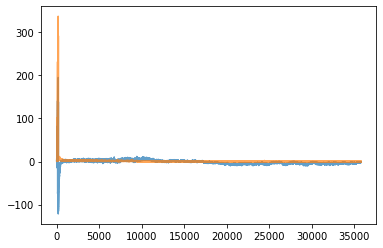

In [14]:
plt.plot(generator_history['generator_loss'],alpha=0.7)
plt.plot(discriminator_history['discriminator_loss'],alpha=0.7)

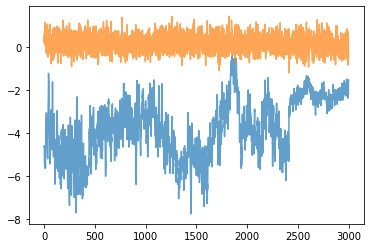

In [15]:
plt.plot(generator_history['generator_loss'][-3000:],alpha=0.7)
plt.plot(discriminator_history['discriminator_loss'][-3000:],alpha=0.7)

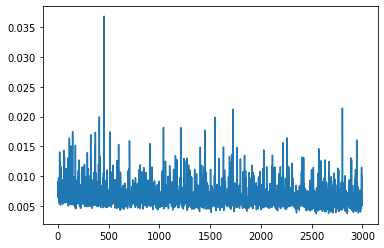

In [16]:
plt.plot(discriminator_history['gradient norm'][-3000:])

torch.Size([100, 3, 32, 32])
['máy bay', 'xe hơi', 'con chim', 'con mèo', 'con hươu', 'con chó', 'con ếch', 'ngựa', 'thuyền', 'xe tải']


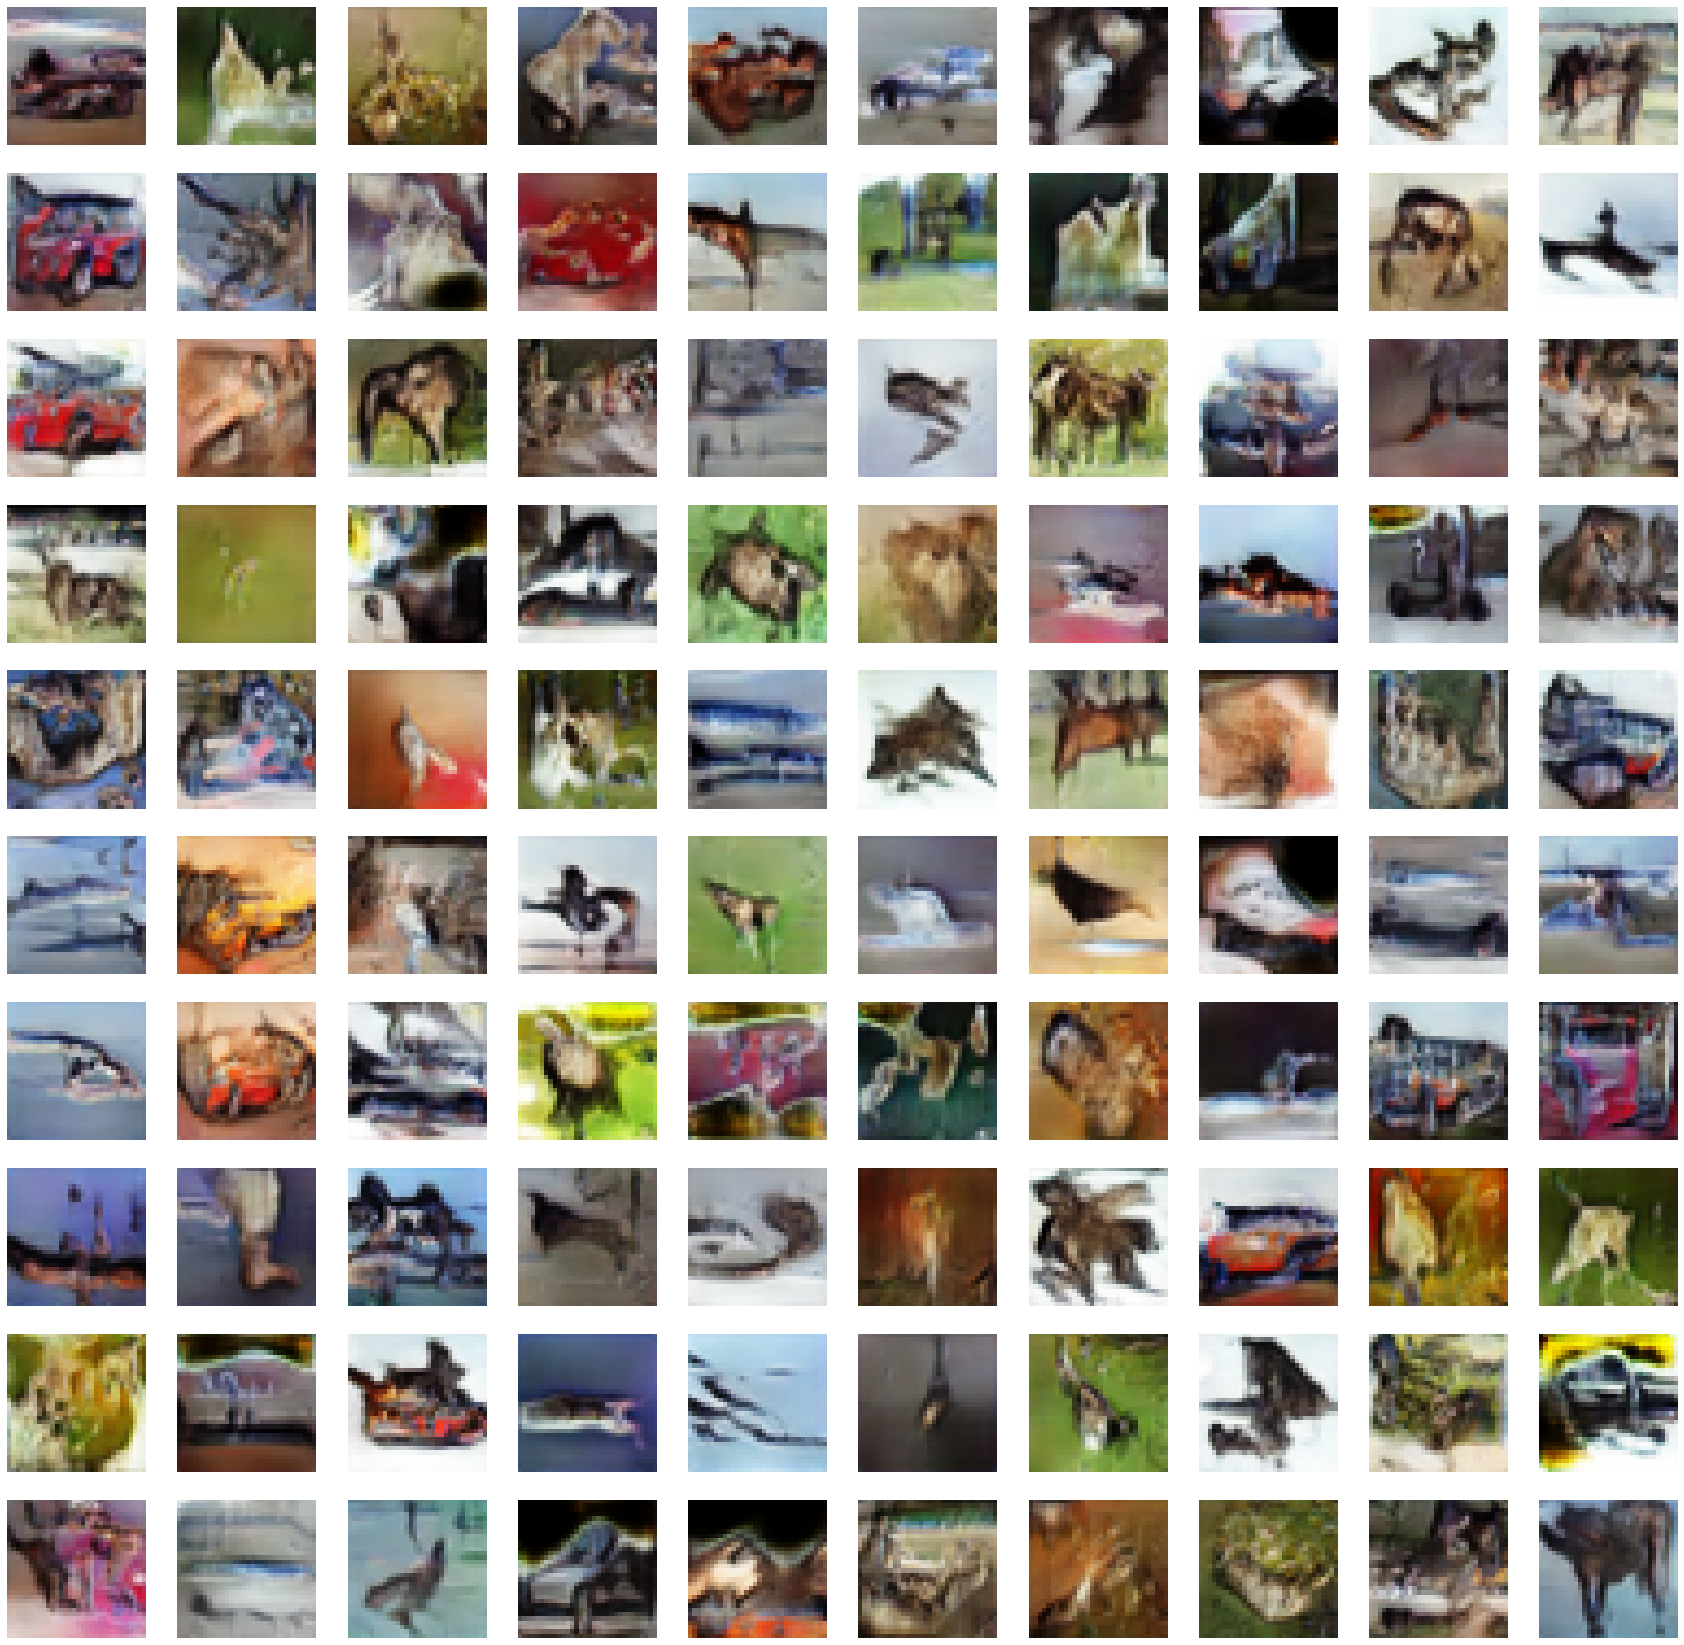

In [17]:
random_vector = torch.empty((100,latent)).normal_(std=1).to(device)
im=generator(random_vector)
print(im.shape)
print(['máy bay','xe hơi','con chim','con mèo','con hươu','con chó','con ếch','ngựa','thuyền','xe tải'])
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(im[i-1].cpu().detach())).squeeze())
plt.show()

In [ ]:
save_model()
print('model saved')

model saved
